In [144]:
#Library Import
import pandas as pd
import numpy as np
import seaborn as sns 
import scipy.cluster.hierarchy as shc
from matplotlib import pyplot as plt

import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression,Lasso,Ridge
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA 

In [107]:
# Data Import
player_stats = pd.read_csv('../Datasets/nba_player_stats_official.csv')
# Average score for each player collected from espn
player_physical = pd.read_csv('../Datasets/data_player.csv')

In [108]:
player_physical.columns

Index(['Unnamed: 0', 'name', 'href', 'uid', 'guid', 'id', 'height', 'weight',
       'age', 'position', 'jersey', 'salary', 'birthDate', 'headshot',
       'lastName', 'experience', 'college', 'birthPlace', 'hand', 'GP', 'GS',
       'MIN', 'FGM', 'FGA', 'FG%', '3PTM', '3PTA', '3P%', 'FTM', 'FTA', 'FT%',
       'OR', 'DR', 'REB', 'AST', 'BLK', 'STL', 'PF', 'TO', 'PTS'],
      dtype='object')

In [109]:
player_att = player_physical[['name','position','height','weight']]

In [110]:
# Merge with NBA official data over the years 
df = pd.merge(player_att,player_stats,how = 'left', left_on=['name'], right_on = ['PLAYER_NAME']).drop(columns = ['PLAYER_NAME']).dropna()

# EDA -  Physical Attribute and Performance

In [172]:
player_physical['age'].describe()

count    506.000000
mean      26.286561
std        4.102993
min       19.000000
25%       23.000000
50%       25.500000
75%       29.000000
max       40.000000
Name: age, dtype: float64

Distribution of the age for all active players

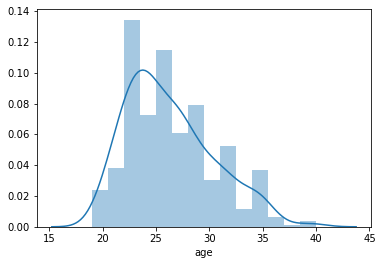

In [173]:
sns.distplot(player_physical['age'])

## Average Performance - ESPN

In [119]:
physical_att = player_physical[['name','position','height','weight','GP','GS', 'MIN', 'FGM',
       'FGA', 'FG%', '3PTM', '3PTA', '3P%', 'FTM', 'FTA', 'FT%', 'OR', 'DR',
       'REB', 'AST', 'BLK', 'STL', 'PF', 'TO', 'PTS']].dropna()

In [120]:
physical_att.height.describe()

count    503.000000
mean      78.447316
std        3.337089
min       69.000000
25%       76.000000
50%       78.000000
75%       81.000000
max       89.000000
Name: height, dtype: float64

In [121]:
physical_att.weight.describe()

count    503.000000
mean     217.773360
std       24.066068
min      167.000000
25%      200.000000
50%      215.000000
75%      235.000000
max      311.000000
Name: weight, dtype: float64

In [122]:
# Standardize the data
physical_att.iloc[:,2:] = physical_att.iloc[:,2:].apply(lambda x: (x-x.mean())/ x.std(), axis=0)

In [128]:
X = physical_att[['height','weight']]

In [133]:
for target in ['GP','GS', 'MIN', 'FGM',
       'FGA', 'FG%', '3PTM', '3PTA', '3P%', 'FTM', 'FTA', 'FT%', 'OR', 'DR',
       'REB', 'AST', 'BLK', 'STL', 'PF', 'TO', 'PTS']:
    X_const = sm.add_constant(X)
    model = sm.OLS(physical_att[target], X)
    res = model.fit()
    print('\nResult Summary {0}:'.format(target))
    _ = print(res.summary2())


Result Summary GP:
                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.027    
Dependent Variable:     GP               AIC:                         1414.8750
Date:                   2020-11-16 16:43 BIC:                         1423.3162
No. Observations:       503              Log-Likelihood:              -705.44  
Df Model:               2                F-statistic:                 7.878    
Df Residuals:           501              Prob (F-statistic):          0.000428 
R-squared (uncentered): 0.030            Scale:                       0.97144  
------------------------------------------------------------------------------------
             Coef.       Std.Err.         t         P>|t|        [0.025       0.975]
------------------------------------------------------------------------------------
height      -0.1669        0.0681      -2.4497      0.0146      -0.3008      -0.0330
weight       0.2649     

                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.050    
Dependent Variable:     3P%              AIC:                         1402.7644
Date:                   2020-11-16 16:43 BIC:                         1411.2056
No. Observations:       503              Log-Likelihood:              -699.38  
Df Model:               2                F-statistic:                 14.17    
Df Residuals:           501              Prob (F-statistic):          1.03e-06 
R-squared (uncentered): 0.054            Scale:                       0.94833  
------------------------------------------------------------------------------------
             Coef.       Std.Err.         t         P>|t|        [0.025       0.975]
------------------------------------------------------------------------------------
height      -0.1869        0.0673      -2.7763      0.0057      -0.3192      -0.0546
weight      -0.0547        0.0673      -0.81

                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.348    
Dependent Variable:     BLK              AIC:                         1213.0753
Date:                   2020-11-16 16:43 BIC:                         1221.5165
No. Observations:       503              Log-Likelihood:              -604.54  
Df Model:               2                F-statistic:                 135.4    
Df Residuals:           501              Prob (F-statistic):          9.66e-48 
R-squared (uncentered): 0.351            Scale:                       0.65040  
------------------------------------------------------------------------------------
                Coef.       Std.Err.        t         P>|t|       [0.025      0.975]
------------------------------------------------------------------------------------
height          0.3662        0.0558      6.5690      0.0000      0.2567      0.4758
weight          0.2635        0.0558      4.

OR (Offensive rebounds per game) - R square is 0.42. 
REB - (rebounds per game) - R square 0.33 
BLK (Block per Game) - R square 0.348
FG - R square 0.237

# Feature of Importance

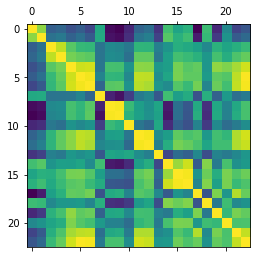

In [192]:
#physical_att.corr()['weight']
plt.matshow(physical_att.corr())
plt.show()

In [194]:
physical_att.corr()[['weight','height']]

,weight,height
height,0.763643,1.000000
weight,1.000000,0.763643
GP,0.137402,0.035350
GS,0.173419,0.072517
MIN,0.051774,-0.037979
FGM,0.129493,0.025876
FGA,0.007140,-0.091823
FG%,0.462934,0.451434
3PTM,-0.318904,-0.342381
3PTA,-0.343789,-0.373513


In [174]:
X_const = sm.add_constant(X)
model = sm.OLS(physical_att['REB'], X)
res = model.fit()
print('\nResult Summary {0}:'.format(target))
_ = print(res.summary2())


Result Summary PTS:
                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.330    
Dependent Variable:     REB              AIC:                         1227.3211
Date:                   2020-11-22 20:05 BIC:                         1235.7623
No. Observations:       503              Log-Likelihood:              -611.66  
Df Model:               2                F-statistic:                 124.6    
Df Residuals:           501              Prob (F-statistic):          1.16e-44 
R-squared (uncentered): 0.332            Scale:                       0.66909  
------------------------------------------------------------------------------------
                Coef.       Std.Err.        t         P>|t|       [0.025      0.975]
------------------------------------------------------------------------------------
height          0.1549        0.0565      2.7396      0.0064      0.0438      0.2660
weight          0.4494 

In [175]:
X_const = sm.add_constant(X)
model = sm.OLS(physical_att['OR'], X)
res = model.fit()
print('\nResult Summary {0}:'.format(target))
_ = print(res.summary2())


Result Summary PTS:
                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.424    
Dependent Variable:     OR               AIC:                         1151.3099
Date:                   2020-11-22 20:05 BIC:                         1159.7511
No. Observations:       503              Log-Likelihood:              -573.65  
Df Model:               2                F-statistic:                 185.8    
Df Residuals:           501              Prob (F-statistic):          4.23e-61 
R-squared (uncentered): 0.426            Scale:                       0.57525  
------------------------------------------------------------------------------------
                Coef.       Std.Err.        t         P>|t|       [0.025      0.975]
------------------------------------------------------------------------------------
height          0.2219        0.0524      4.2313      0.0000      0.1188      0.3249
weight          0.4673 

In [176]:
X_const = sm.add_constant(X)
model = sm.OLS(physical_att['BLK'], X)
res = model.fit()
print('\nResult Summary {0}:'.format(target))
_ = print(res.summary2())


Result Summary PTS:
                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.348    
Dependent Variable:     BLK              AIC:                         1213.0753
Date:                   2020-11-22 20:06 BIC:                         1221.5165
No. Observations:       503              Log-Likelihood:              -604.54  
Df Model:               2                F-statistic:                 135.4    
Df Residuals:           501              Prob (F-statistic):          9.66e-48 
R-squared (uncentered): 0.351            Scale:                       0.65040  
------------------------------------------------------------------------------------
                Coef.       Std.Err.        t         P>|t|       [0.025      0.975]
------------------------------------------------------------------------------------
height          0.3662        0.0558      6.5690      0.0000      0.2567      0.4758
weight          0.2635 

# NBA Official Data

In [220]:
cluster = player_stats[['year','PLAYER_NAME','GP', 'MIN', 'FG_PCT', 'FGM', 'FGA', 'FG3M', 'FG3A',
    'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 
    'REB', 'AST', 'BLK', 'STL', 'PF', 'TOV', 'PTS']]

In [218]:
cluster.MIN.describe()

count    11161.000000
mean        20.329074
std         10.046348
min          0.100000
25%         12.000000
50%         19.700000
75%         28.600000
max         43.700000
Name: MIN, dtype: float64

In [219]:
cluster.GP.describe()

count    11161.000000
mean        52.150972
std         25.094878
min          1.000000
25%         32.000000
50%         59.000000
75%         74.000000
max         85.000000
Name: GP, dtype: float64

In [221]:
cluster = cluster [(cluster.MIN > 23) & (cluster.GP > 15) & (cluster.year == '2019-20')].reset_index(drop=True)
cluster = cluster.drop_duplicates()

In [157]:
df[(df.name == 'Brandon Ingram') | (df.name == 'Pascal Siakam') ][['year','name','GP', 'MIN', 'FG_PCT', 'FGM', 'FGA', 'FG3M', 'FG3A',
    'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 
    'REB', 'AST', 'BLK', 'STL', 'PF', 'TOV', 'PTS']]

,year,name,GP,MIN,FG_PCT,FGM,FGA,FG3M,FG3A,FG3_PCT,...,FT_PCT,OREB,DREB,REB,AST,BLK,STL,PF,TOV,PTS
412,2016-17,Pascal Siakam,55.0,15.6,0.502,1.9,3.7,0.0,0.1,0.143,...,0.688,1.2,2.2,3.4,0.3,0.8,0.5,2.0,0.6,4.2
413,2017-18,Pascal Siakam,81.0,20.7,0.508,3.1,6.1,0.4,1.6,0.220,...,0.621,1.0,3.5,4.5,2.0,0.5,0.8,2.0,0.8,7.3
414,2018-19,Pascal Siakam,80.0,31.8,0.549,6.5,11.8,1.0,2.7,0.369,...,0.785,1.6,5.3,6.9,3.1,0.7,0.9,3.0,1.9,16.9
415,2019-20,Pascal Siakam,60.0,35.2,0.453,8.3,18.4,2.2,6.1,0.359,...,0.792,1.1,6.3,7.3,3.5,0.9,1.0,2.8,2.5,22.9
2350,2016-17,Brandon Ingram,79.0,28.9,0.402,3.5,8.7,0.7,2.4,0.294,...,0.621,0.8,3.2,4.0,2.1,0.5,0.6,2.0,1.5,9.4
2351,2017-18,Brandon Ingram,59.0,33.5,0.470,6.1,12.9,0.7,1.8,0.390,...,0.681,1.0,4.4,5.3,3.9,0.7,0.8,2.8,2.5,16.1
2352,2018-19,Brandon Ingram,52.0,33.9,0.497,7.0,14.0,0.6,1.8,0.330,...,0.675,0.8,4.3,5.1,3.0,0.6,0.5,2.9,2.5,18.3
2353,2019-20,Brandon Ingram,62.0,33.9,0.463,8.2,17.7,2.4,6.2,0.391,...,0.851,0.8,5.3,6.1,4.2,0.6,1.0,2.9,3.0,23.8


Ward's method is the distance between two clusters how much the sum of squares will increase when merging the two clusters. Take center of cluster j and n is the number of points in the cluster j. We have a merging cost combine the clusters A and B.  Minimize the variance of the clusters being merged.
Ref:https://www.stat.cmu.edu/~cshalizi/350/lectures/08/lecture-08.pdf

Ward - uses Ward Variance minimization algorithm -
The clusters are merged if the increase in the combined variance over the sum of the cluster-specific variances is the minimum compared to alternative merging operations.

single - nearest point algorithm 
complete - farthest point algorithm

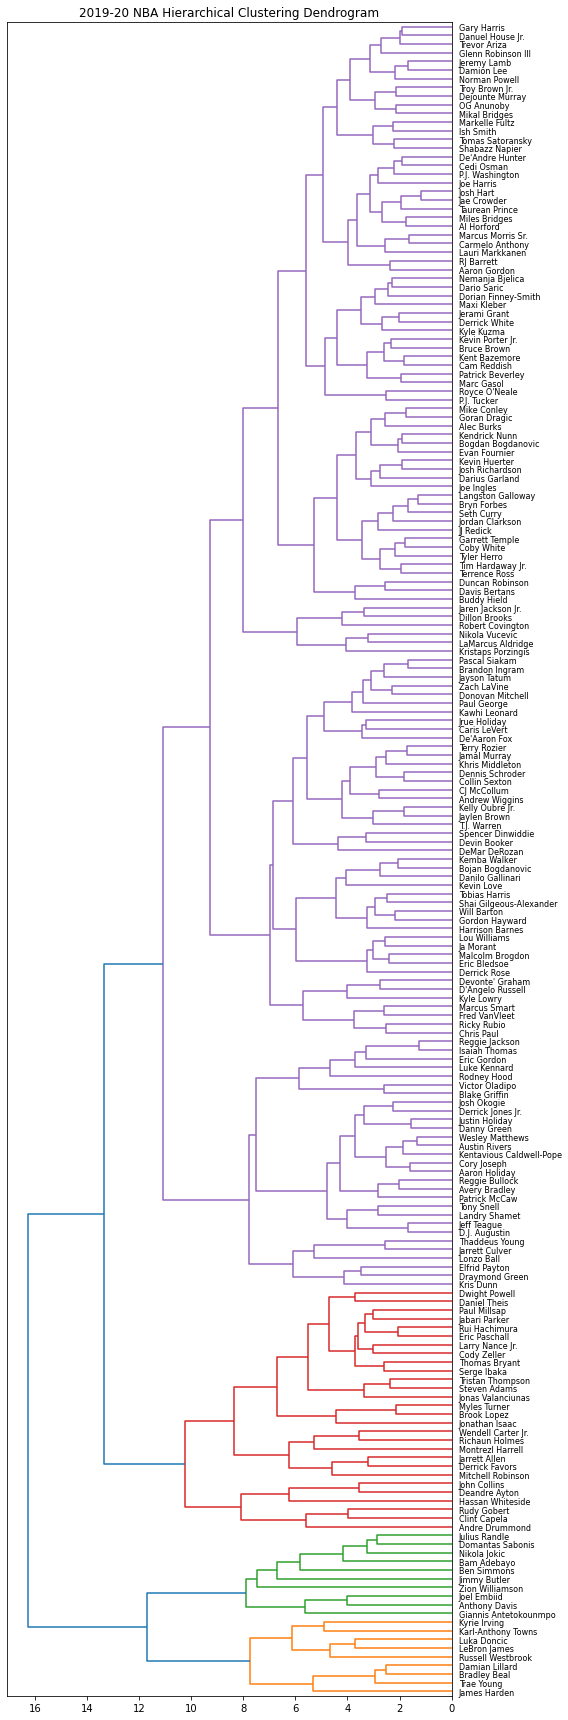

In [222]:
features = [x for x in cluster.columns if (x != 'PLAYER_NAME') &  (x != 'year') ]

x = cluster.loc[:, features].values
y = cluster.loc[:,['PLAYER_NAME']].values

x = StandardScaler().fit_transform(x) # standardize all values

pca = PCA(n_components=0.99)
principalComponents = pca.fit_transform(x)

plt.figure(figsize=(8,24))
plt.title('2019-20 NBA Hierarchical Clustering Dendrogram')
dend = shc.dendrogram(shc.linkage(principalComponents, method='complete'),labels=list(cluster.PLAYER_NAME),orientation='left')

plt.yticks(fontsize=8)

plt.tight_layout()

plt.show()

In [223]:
similarity_matrix = shc.linkage(principalComponents, method='ward')

In [224]:
similarity_matrix

array([[ 80.        ,  99.        ,   1.16037309,   2.        ],
       [ 75.        , 157.        ,   1.23441413,   2.        ],
       [ 18.        , 123.        ,   1.30547346,   2.        ],
       [  7.        , 189.        ,   1.33582569,   2.        ],
       [ 37.        , 104.        ,   1.54991684,   2.        ],
       [  1.        ,  30.        ,   1.58073432,   2.        ],
       [ 23.        , 133.        ,   1.62450902,   2.        ],
       [ 34.        ,  90.        ,   1.6717191 ,   2.        ],
       [ 15.        , 150.        ,   1.67353395,   2.        ],
       [ 32.        ,  88.        ,   1.68641143,   2.        ],
       [ 81.        , 175.        ,   1.72431571,   2.        ],
       [  2.        , 139.        ,   1.73571777,   2.        ],
       [ 71.        , 138.        ,   1.75052382,   2.        ],
       [111.        , 196.        ,   1.75366463,   3.        ],
       [167.        , 195.        ,   1.75786151,   3.        ],
       [ 27.        ,  67

Linkage matrix Z: At the i-th interation, clusters with indices Z[i,0] and Z[i,1] are combined to form cluster n + i. Distance of Z[i,0] Z[i,1] is given by Z[i,2]. The fourth value Z[i,3] represents the number of original observations in the newly formed cluster

In [208]:
similarity_matrix

array([[ 80.        ,  99.        ,   1.16037309,   2.        ],
       [ 75.        , 157.        ,   1.23441413,   2.        ],
       [ 18.        , 123.        ,   1.30547346,   2.        ],
       [  7.        , 189.        ,   1.33582569,   2.        ],
       [ 37.        , 104.        ,   1.54991684,   2.        ],
       [  1.        ,  30.        ,   1.58073432,   2.        ],
       [ 23.        , 133.        ,   1.62450902,   2.        ],
       [ 34.        ,  90.        ,   1.6717191 ,   2.        ],
       [ 15.        , 150.        ,   1.67353395,   2.        ],
       [ 32.        ,  88.        ,   1.68641143,   2.        ],
       [ 81.        , 175.        ,   1.72431571,   2.        ],
       [  2.        , 139.        ,   1.73571777,   2.        ],
       [ 71.        , 138.        ,   1.75052382,   2.        ],
       [111.        , 196.        ,   1.75366463,   3.        ],
       [167.        , 195.        ,   1.75786151,   3.        ],
       [ 27.        ,  67

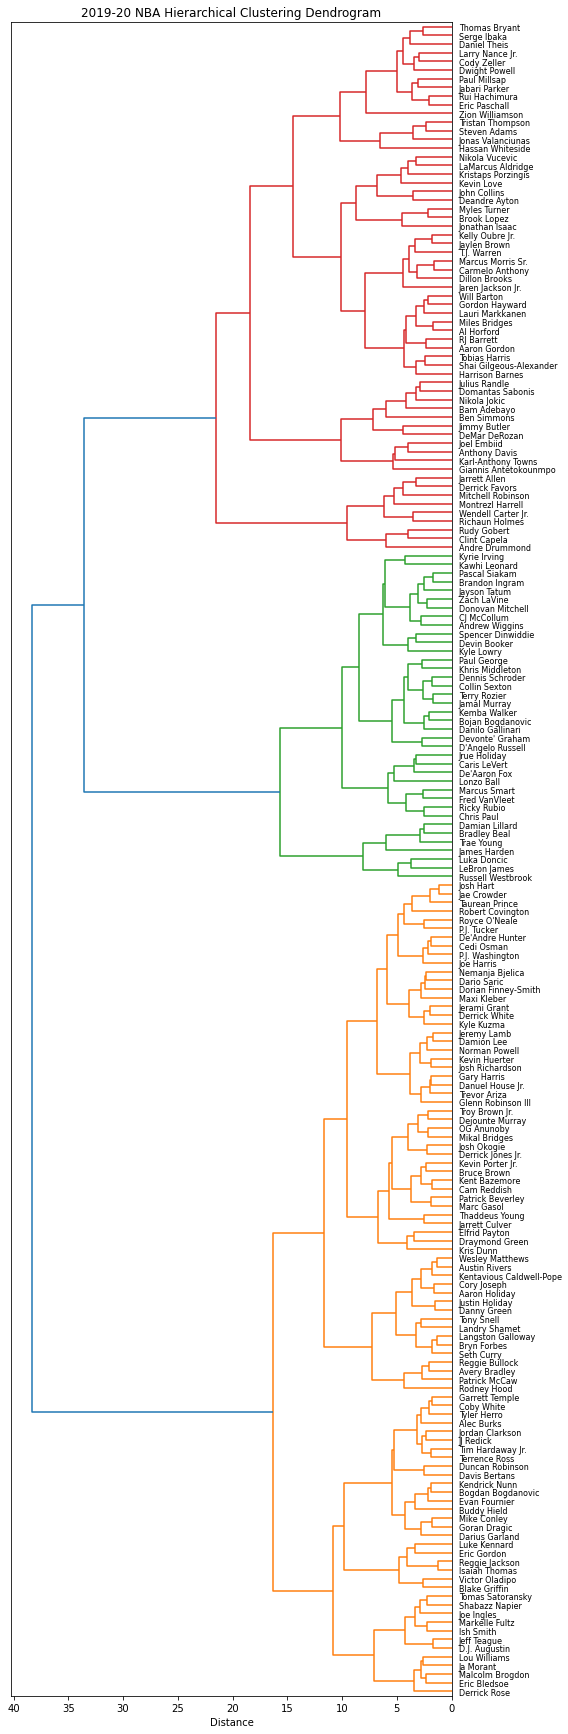

In [205]:
plt.figure(figsize=(8,24))
plt.title('2019-20 NBA Hierarchical Clustering Dendrogram')
dend = shc.dendrogram(shc.linkage(principalComponents, method='ward'),labels=list(cluster.PLAYER_NAME),orientation='left')

plt.yticks(fontsize=8)

plt.tight_layout()
plt.xlabel('Distance')
plt.show()

In [215]:
cluster.iloc[91]

year                2019-20
PLAYER_NAME    Jimmy Butler
GP                       58
MIN                    33.8
FG_PCT                0.455
FGM                     5.9
FGA                    13.1
FG3M                    0.5
FG3A                    2.1
FG3_PCT               0.244
FTM                     7.6
FTA                     9.1
FT_PCT                0.834
OREB                    1.8
DREB                    4.8
REB                     6.7
AST                       6
BLK                     0.6
STL                     1.8
PF                      1.4
TOV                     2.2
PTS                    19.9
Name: 91, dtype: object

In [216]:
cluster.iloc[44]

year                 2019-20
PLAYER_NAME    DeMar DeRozan
GP                        68
MIN                     34.1
FG_PCT                 0.531
FGM                      8.2
FGA                     15.4
FG3M                     0.1
FG3A                     0.5
FG3_PCT                0.257
FTM                      5.6
FTA                      6.6
FT_PCT                 0.845
OREB                     0.6
DREB                     4.9
REB                      5.5
AST                      5.6
BLK                      0.3
STL                        1
PF                       2.6
TOV                      2.4
PTS                     22.1
Name: 44, dtype: object

As one of the example, both of them are shooting guard with similar performance. Similarity score between these two palyers is 4.4.

# How Hierarchical Agglomerative Clustering works? 
Each player is one cluster at the beginning. Then it will repeat two steps:
1. identify the two clusters that are closest together based on the distance 
2. Merge two most similar clusters togther as one 
Repeat this process until all players are in the same cluster. The dendrogram is a way to show how each player get grouped. 

The distance, we have different ways to define. 

- If there is no clear theoretical justification for the choice of linkage criteria, Ward's method is the sensible default. It describes how much the sum of squares will increase when you merge two clusters. This method will calculate the center of the cluster and calculate the sum of square. 



Ward: 
- spherical tightly bound clusters 
- less sensitive to outliers

Single-linkage: 
- smallest minimum distance between two points, One from each of the cluster as a reference of clustering. (n^2) 
- Drawback: chaining, only need to one pair to be close. Cluster can be too spread out and not compact enough. 

Complete-linkage: 
- smallest maximum distance between two points, One from each of the cluster as a reference of clustering. (n^2 log n) 
- Drawback: avoid chaining, but suffers from crowding. Clusters are compact but not far enough apart

average-linkage:
- compromise between the sensitivity of complete-link clustering to outliers and the tendency of single-link clustering to form long chains that do not correpond to the intuitive notion of clustering as compact spherical objects. average linkage score from all points to one point. 
- strike a balance. It uses average pariwise dissimilartiy, so clusters tend to be relatively compact and relatively far apart.
- Drawback: not clear what properties the resuling clusters have when cut an average linkage tree at a given distance. 

In [166]:
cluster06 = player_stats[['year','PLAYER_NAME','GP', 'MIN', 'FG_PCT', 'FGM', 'FGA', 'FG3M', 'FG3A',
    'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 
    'REB', 'AST', 'BLK', 'STL', 'PF', 'TOV', 'PTS']]
cluster06 = cluster06 [(cluster06.MIN > 23) & (cluster06.GP > 15)
                       & (cluster06.year == '2006-07')].reset_index(drop=True)

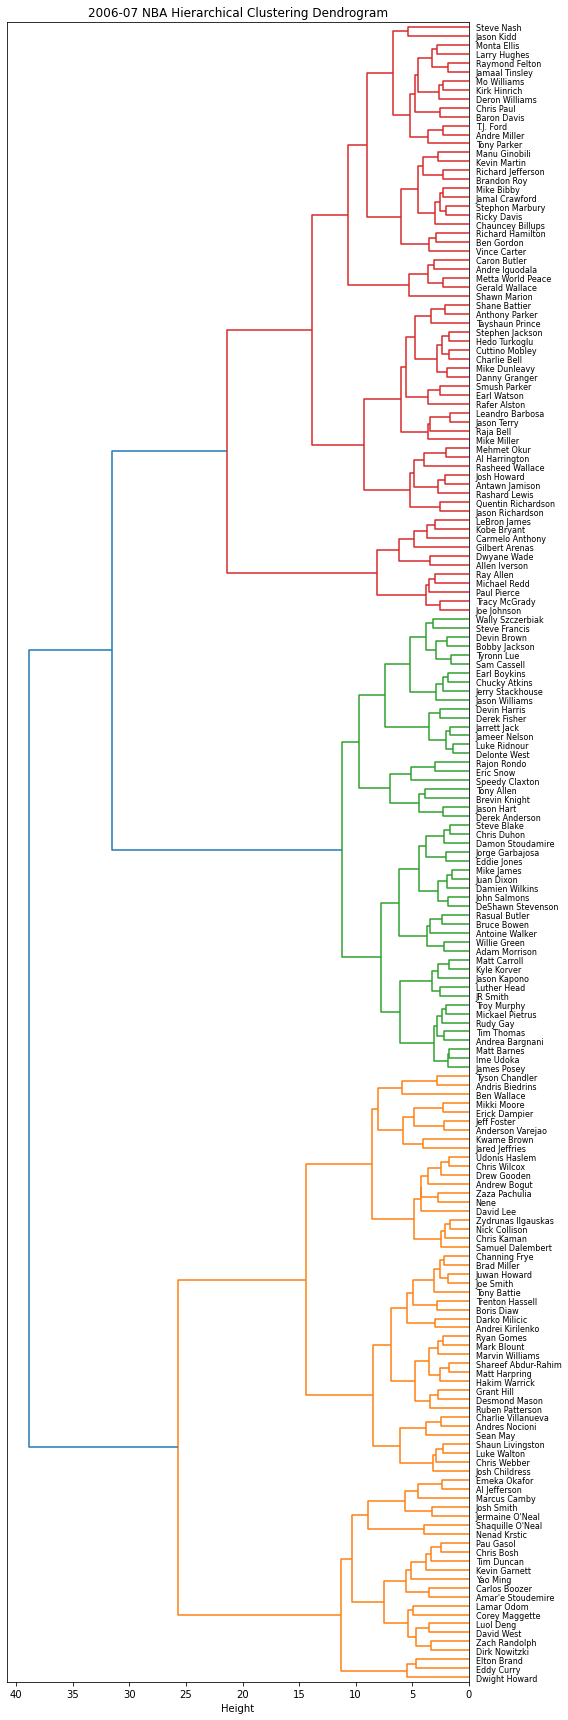

In [169]:
features = [x for x in cluster06.columns if (x != 'PLAYER_NAME') &  (x != 'year') ]

x = cluster06.loc[:, features].values
y = cluster06.loc[:,['PLAYER_NAME']].values

x = StandardScaler().fit_transform(x) # standardize all values

pca = PCA(n_components=0.99)
principalComponents = pca.fit_transform(x)

plt.figure(figsize=(8,24))
plt.title('2006-07 NBA Hierarchical Clustering Dendrogram')
dend = shc.dendrogram(shc.linkage(x, method='ward'),labels=list(cluster06.PLAYER_NAME),orientation='left')

plt.yticks(fontsize=8)
plt.xlabel('Distance')

plt.tight_layout()

plt.show()

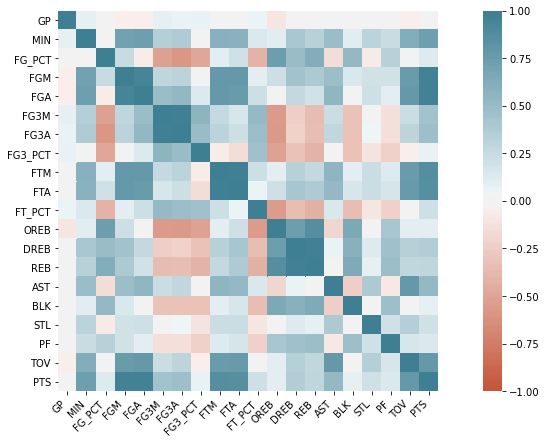

In [171]:
corr = cluster.corr()
plt.figure(figsize=[16,7])
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [99]:
physical.year.unique()

array(['2016-17', '2017-18', '2018-19', '2019-20', '2010-11', '2011-12',
       '2012-13', '2013-14', '2014-15', '2015-16', '2007-08', '2008-09',
       '2009-10', '2000-01', '2001-02', '2002-03', '2003-04', '2004-05',
       '2005-06', '2006-07'], dtype=object)